## **Question 2. Image Classification**

1. Download the Kaggle Cats and Dogs dataset and select a subset of 2000 dog images and 2000 cat images for training, validation, and testing. The reduced dataset simulates the cond ition of
limited data.

2. Build a convolutional neural network (CNN) with several convolution, pooling, and normalization layers, followed by one or more dense layers. Flatten the output between the convolution and
dense layers. Evaluate the model's performance on the validation set.

3. Modify the data generator to include data augmentation, and evaluate the performance on the validation set again.

4. Replace the convolution layers with a pre-trained VGG16 convolutional base, and evaluate the model's performance on the validation set.

5. Evaluate the algorithm and report results.

In [1]:
# Import necessary libraries
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the random seed
seed = 512
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## **Data Construction for Train**

In [2]:
# Set the source and target directories
source_dir = './PetImages'  # Directory containing the original dataset
target_dir = './CatsAndDogs'  # Directory where the new dataset will be stored

# Create the target directory if it doesn't already exist
os.makedirs(target_dir, exist_ok=True)

# Create subdirectories for cats and dogs in the target directory
cat_dir = os.path.join(target_dir, 'Cat')
dog_dir = os.path.join(target_dir, 'Dog')
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Randomly select 2000 images from each class (Cats and Dogs)
cat_images = random.sample(os.listdir(os.path.join(source_dir, 'Cat')), 2000)
dog_images = random.sample(os.listdir(os.path.join(source_dir, 'Dog')), 2000)

# Copy the selected cat images to the target directory
for img in cat_images:
    source_path = os.path.join(source_dir, 'Cat', img)
    target_path = os.path.join(cat_dir, img)
    # Copy the image only if it doesn't already exist in the target directory
    if not os.path.exists(target_path):
        shutil.copy(source_path, target_path)

# Copy the selected dog images to the target directory
for img in dog_images:
    source_path = os.path.join(source_dir, 'Dog', img)
    target_path = os.path.join(dog_dir, img)
    # Copy the image only if it doesn't already exist in the target directory
    if not os.path.exists(target_path):
        shutil.copy(source_path, target_path)

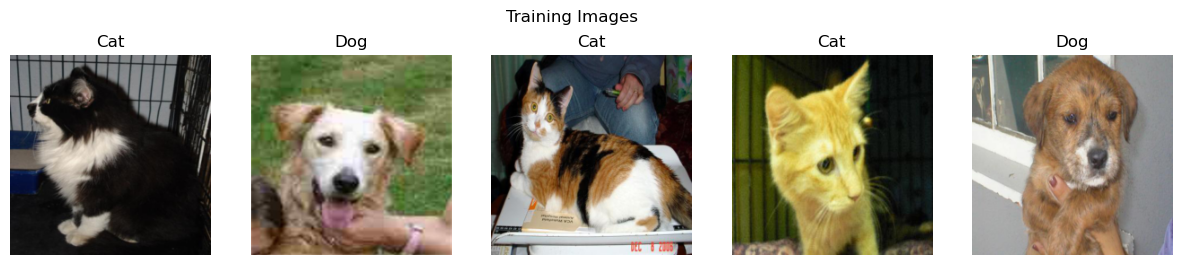

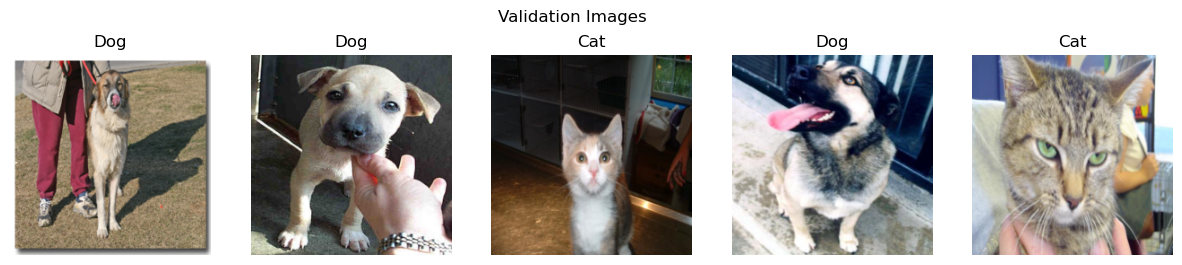

In [3]:
# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset from the target directory with the defined transformations
dataset = datasets.ImageFolder(target_dir, transform=transform)

# Split the dataset into training (70%) and validation (30%) sets
train_size = int(0.7 * len(dataset))  # Calculate the size of the training set (70%)
val_size = len(dataset) - train_size  # The rest goes to the validation set (30%)

# Use random_split to create the training and validation datasets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader objects for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Function to display a batch of images from the DataLoader
def display_images(loader, title, num_images=5):
    # Get a batch of images and labels
    images, labels = next(iter(loader))

    plt.figure(figsize=(15, 3))

    for i in range(num_images):
        # Get the i-th image and label from the batch
        image = images[i]
        label = labels[i].item()  # Convert label tensor to scalar

        # Rearrange the tensor dimensions from (C, H, W) to (H, W, C) for plotting
        image = image.permute(1, 2, 0).numpy()

        # Plot the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'{"Cat" if label == 0 else "Dog"}')

    plt.suptitle(title)
    plt.show()

# Display 5 random images from the training DataLoader
display_images(train_loader, "Training Images", num_images=5)

# Display 5 random images from the validation DataLoader
display_images(val_loader, "Validation Images", num_images=5)


## **Design Simple CNN Model**

In [4]:
# Define a simple Convolutional Neural Network (CNN) model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer: input (3 channels), output (32 channels), kernel size 3x3, padding=1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # Batch Normalization after the first convolution
        self.bn1 = nn.BatchNorm2d(32)
        
        # Max pooling layer: reduces the spatial dimensions by half (2x2 kernel)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer: input (32 channels), output (64 channels), kernel size 3x3, padding=1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Batch Normalization after the second convolution
        self.bn2 = nn.BatchNorm2d(64)
        
        # Fully connected layer 1: input size 64*56*56 (after pooling), output size 512
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        
        # Fully connected layer 2: input size 512, output size 2 (binary classification - cat or dog)
        self.fc2 = nn.Linear(512, 2)
        
        # ReLU activation function
        self.relu = nn.ReLU()

    # Define the forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the output
        x = x.view(-1, 64 * 56 * 56)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## **Train and Evaluate Code**

In [5]:
# Function to train the model and track loss and accuracy during training
def train_evaluate_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device):
    train_losses = []     # List to store the training loss per epoch
    val_accuracies = []   # List to store the validation accuracy per epoch
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the cumulative loss during the epoch

        # Progress bar to show the training progress for each epoch
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients before each step
            outputs = model(inputs)  # Forward pass: compute the model output
            loss = criterion(outputs, labels)  # Compute the loss based on the model output and true labels
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters based on the gradients

            running_loss += loss.item()  # Accumulate the loss
            progress_bar.set_postfix(loss=running_loss / len(train_loader))  # Display the loss on the progress bar

        # Append the average loss for this epoch to the list
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Evaluate the model on the validation set and store the validation accuracy
        val_accuracy = evaluate_model(model, val_loader, device)
        val_accuracies.append(val_accuracy)

    return train_losses, val_accuracies

# Function to evaluate the model's performance on the validation set
def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0   # Track the number of correct predictions
    total = 0     # Track the total number of predictions

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the selected device
            outputs = model(inputs)  # Forward pass: compute the model output
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with the highest score
            total += labels.size(0)  # Update the total number of predictions
            correct += (predicted == labels).sum().item()  # Count the number of correct predictions

    val_accuracy = 100 * correct / total  # Calculate the accuracy as a percentage
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    
    return val_accuracy

## **Set Parameters**

In [6]:
# Set the number of epochs and learning rate for training
num_epochs = 100  # Number of times the model will iterate through the entire training set
learning_rate = 0.001  # Step size for updating model weights

# Check if GPU is available, otherwise use CPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Print the device being used (CUDA or CPU)

# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

# Initialize a dictionary to store results for training and evaluation
results = {}

Using device: cuda


## **Train SimpleCNN**

In [7]:
# Initialize the Simple CNN model
model_simple_cnn = SimpleCNN().to(device)

# Define the Adam optimizer, using the model's parameters and the defined learning rate
optimizer_simple_cnn = optim.Adam(model_simple_cnn.parameters(), lr=learning_rate)

# Train the model and evaluate it on the validation set
# This function will return the training losses and validation accuracies for each epoch
print(f"{'*' * 20}Train Simple CNN{'*' * 20}")
train_losses_simple, val_accuracies_simple = train_evaluate_model(
    model_simple_cnn, 
    criterion, 
    optimizer_simple_cnn, 
    num_epochs, 
    train_loader,
    val_loader, 
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['Simple CNN'] = (train_losses_simple, val_accuracies_simple)


********************Train Simple CNN********************


Epoch 1/100: 100%|██████████| 44/44 [00:13<00:00,  3.30it/s, loss=15.5] 


Validation Accuracy: 61.08%


Epoch 2/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=1.46] 


Validation Accuracy: 63.50%


Epoch 3/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.72] 


Validation Accuracy: 64.92%


Epoch 4/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.973]


Validation Accuracy: 66.00%


Epoch 5/100: 100%|██████████| 44/44 [00:12<00:00,  3.40it/s, loss=0.651] 


Validation Accuracy: 66.67%


Epoch 6/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.408] 


Validation Accuracy: 65.58%


Epoch 7/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.285] 


Validation Accuracy: 62.17%


Epoch 8/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.363] 


Validation Accuracy: 67.33%


Epoch 9/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.428] 


Validation Accuracy: 68.25%


Epoch 10/100: 100%|██████████| 44/44 [00:12<00:00,  3.41it/s, loss=0.195] 


Validation Accuracy: 68.33%


Epoch 11/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.194] 


Validation Accuracy: 68.58%


Epoch 12/100: 100%|██████████| 44/44 [00:13<00:00,  3.34it/s, loss=0.185] 


Validation Accuracy: 67.42%


Epoch 13/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.138] 


Validation Accuracy: 68.08%


Epoch 14/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.135] 


Validation Accuracy: 69.00%


Epoch 15/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=0.069] 


Validation Accuracy: 67.58%


Epoch 16/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=0.0965] 


Validation Accuracy: 68.08%


Epoch 17/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.122] 


Validation Accuracy: 66.67%


Epoch 18/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.221] 


Validation Accuracy: 65.83%


Epoch 19/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.2]   


Validation Accuracy: 68.92%


Epoch 20/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.0715] 


Validation Accuracy: 64.75%


Epoch 21/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.0978]


Validation Accuracy: 68.75%


Epoch 22/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.0483] 


Validation Accuracy: 68.08%


Epoch 23/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.018]  


Validation Accuracy: 68.25%


Epoch 24/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.00912]


Validation Accuracy: 68.92%


Epoch 25/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.00555]


Validation Accuracy: 68.33%


Epoch 26/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.00426]


Validation Accuracy: 69.67%


Epoch 27/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.00332] 


Validation Accuracy: 69.00%


Epoch 28/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.00227] 


Validation Accuracy: 70.00%


Epoch 29/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.00202] 


Validation Accuracy: 69.67%


Epoch 30/100: 100%|██████████| 44/44 [00:12<00:00,  3.40it/s, loss=0.00197] 


Validation Accuracy: 69.58%


Epoch 31/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.00174] 


Validation Accuracy: 70.00%


Epoch 32/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.00157] 


Validation Accuracy: 69.42%


Epoch 33/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.00135] 


Validation Accuracy: 69.33%


Epoch 34/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.00127] 


Validation Accuracy: 69.08%


Epoch 35/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.00105] 


Validation Accuracy: 69.17%


Epoch 36/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.0011]  


Validation Accuracy: 69.75%


Epoch 37/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000988]


Validation Accuracy: 69.33%


Epoch 38/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000897]


Validation Accuracy: 70.00%


Epoch 39/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000905]


Validation Accuracy: 69.00%


Epoch 40/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000868]


Validation Accuracy: 69.50%


Epoch 41/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000782]


Validation Accuracy: 70.08%


Epoch 42/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000768]


Validation Accuracy: 69.33%


Epoch 43/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000712]


Validation Accuracy: 69.83%


Epoch 44/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000729]


Validation Accuracy: 70.00%


Epoch 45/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.000605]


Validation Accuracy: 69.83%


Epoch 46/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.000548]


Validation Accuracy: 69.50%


Epoch 47/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000544]


Validation Accuracy: 70.17%


Epoch 48/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000542]


Validation Accuracy: 69.75%


Epoch 49/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000501]


Validation Accuracy: 70.33%


Epoch 50/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000471]


Validation Accuracy: 69.58%


Epoch 51/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000447]


Validation Accuracy: 69.75%


Epoch 52/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000406]


Validation Accuracy: 70.17%


Epoch 53/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000457]


Validation Accuracy: 69.50%


Epoch 54/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000556]


Validation Accuracy: 69.58%


Epoch 55/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.00051] 


Validation Accuracy: 69.58%


Epoch 56/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000358]


Validation Accuracy: 70.00%


Epoch 57/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000382]


Validation Accuracy: 69.75%


Epoch 58/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000322]


Validation Accuracy: 70.08%


Epoch 59/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000313]


Validation Accuracy: 69.67%


Epoch 60/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000277]


Validation Accuracy: 69.92%


Epoch 61/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000331]


Validation Accuracy: 69.83%


Epoch 62/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000286]


Validation Accuracy: 69.83%


Epoch 63/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000262]


Validation Accuracy: 69.83%


Epoch 64/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000244]


Validation Accuracy: 70.17%


Epoch 65/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000226]


Validation Accuracy: 69.92%


Epoch 66/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000284]


Validation Accuracy: 69.67%


Epoch 67/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000218]


Validation Accuracy: 69.75%


Epoch 68/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000266]


Validation Accuracy: 69.75%


Epoch 69/100: 100%|██████████| 44/44 [00:13<00:00,  3.33it/s, loss=0.000217]


Validation Accuracy: 69.83%


Epoch 70/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.000187]


Validation Accuracy: 69.50%


Epoch 71/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=0.000196]


Validation Accuracy: 69.92%


Epoch 72/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=0.000173]


Validation Accuracy: 69.75%


Epoch 73/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.00016] 


Validation Accuracy: 69.92%


Epoch 74/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000183]


Validation Accuracy: 69.83%


Epoch 75/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000159]


Validation Accuracy: 69.42%


Epoch 76/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.000167]


Validation Accuracy: 69.67%


Epoch 77/100: 100%|██████████| 44/44 [00:12<00:00,  3.38it/s, loss=0.000152]


Validation Accuracy: 69.92%


Epoch 78/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000142]


Validation Accuracy: 69.75%


Epoch 79/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000136]


Validation Accuracy: 70.00%


Epoch 80/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.000142]


Validation Accuracy: 69.83%


Epoch 81/100: 100%|██████████| 44/44 [00:12<00:00,  3.39it/s, loss=0.00013] 


Validation Accuracy: 69.75%


Epoch 82/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=0.000121]


Validation Accuracy: 69.83%


Epoch 83/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000114]


Validation Accuracy: 69.92%


Epoch 84/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=0.000119]


Validation Accuracy: 69.42%


Epoch 85/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=0.000107]


Validation Accuracy: 69.67%


Epoch 86/100: 100%|██████████| 44/44 [00:13<00:00,  3.34it/s, loss=0.000122]


Validation Accuracy: 69.83%


Epoch 87/100: 100%|██████████| 44/44 [00:13<00:00,  3.33it/s, loss=0.000108]


Validation Accuracy: 69.83%


Epoch 88/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=9.58e-5]


Validation Accuracy: 69.75%


Epoch 89/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=9.68e-5]


Validation Accuracy: 69.58%


Epoch 90/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000115]


Validation Accuracy: 70.08%


Epoch 91/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=9.55e-5]


Validation Accuracy: 69.83%


Epoch 92/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=0.000102]


Validation Accuracy: 69.75%


Epoch 93/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=9.34e-5]


Validation Accuracy: 69.92%


Epoch 94/100: 100%|██████████| 44/44 [00:13<00:00,  3.34it/s, loss=9.63e-5]


Validation Accuracy: 69.83%


Epoch 95/100: 100%|██████████| 44/44 [00:13<00:00,  3.37it/s, loss=7.84e-5]


Validation Accuracy: 69.58%


Epoch 96/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=8.86e-5]


Validation Accuracy: 69.75%


Epoch 97/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=7.59e-5]


Validation Accuracy: 70.08%


Epoch 98/100: 100%|██████████| 44/44 [00:13<00:00,  3.36it/s, loss=7.56e-5]


Validation Accuracy: 69.92%


Epoch 99/100: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s, loss=7.23e-5]


Validation Accuracy: 70.25%


Epoch 100/100: 100%|██████████| 44/44 [00:13<00:00,  3.38it/s, loss=7.35e-5]


Validation Accuracy: 69.83%


## **Data Augmentation**

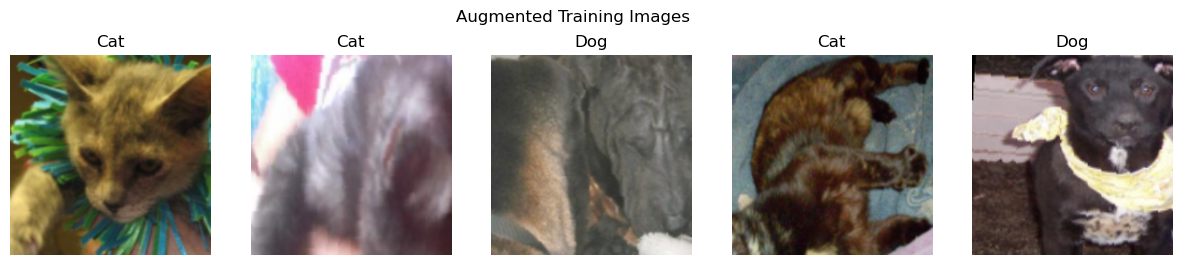

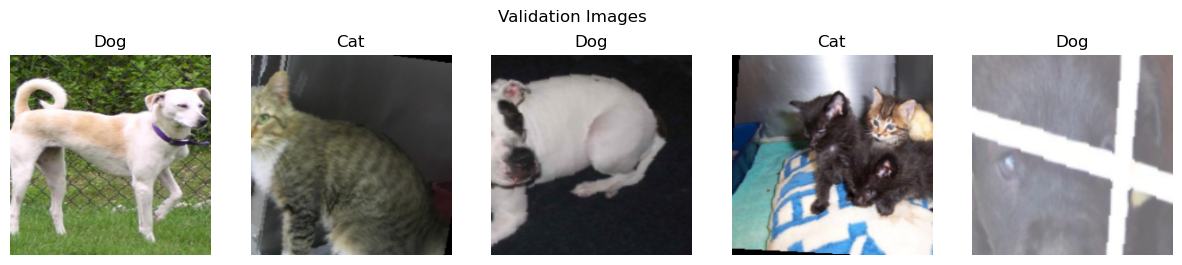

In [8]:
# Define data transformations with data augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally
    transforms.RandomRotation(10),           # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(224),       # Randomly crop and resize the image to 224x224
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
])

# Define transformations for the validation dataset without augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load the dataset using the new transformations
train_dataset_augmented = datasets.ImageFolder(target_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(target_dir, transform=val_transform)

# Split the dataset into training (70%) and validation (30%) sets
train_size = int(0.7 * len(train_dataset_augmented))
val_size = len(train_dataset_augmented) - train_size

# Randomly split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset_augmented, [train_size, val_size])

# Create DataLoader objects for the training and validation datasets
train_loader_augmented = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Display 5 random images from the augmented training DataLoader
display_images(train_loader_augmented, "Augmented Training Images", num_images=5)

# Display 5 random images from the validation DataLoader
display_images(val_loader, "Validation Images", num_images=5)

## **Train SimpleCNN with Data Agumentation**

In [9]:
# Initialize the Simple CNN model with augmentation and move it to the device (CPU or GPU)
model_augmented = SimpleCNN().to(device)

# Define the Adam optimizer with the same learning rate
optimizer_augmented = optim.Adam(model_augmented.parameters(), lr=learning_rate)

# Train the model using the training loader with data augmentation and evaluate it on the validation set
print(f"{'*' * 20}Train Simple CNN with Augmentation{'*' * 20}")
train_losses_augmented, val_accuracies_augmented = train_evaluate_model(
    model_augmented, 
    criterion, 
    optimizer_augmented, 
    num_epochs, 
    train_loader_augmented,  # Use the augmented training data
    val_loader,
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['CNN with Augmentation'] = (train_losses_augmented, val_accuracies_augmented)

********************Train Simple CNN with Augmentation********************


Epoch 1/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=17.6] 


Validation Accuracy: 49.42%


Epoch 2/100: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s, loss=0.747]


Validation Accuracy: 51.00%


Epoch 3/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.688]


Validation Accuracy: 50.92%


Epoch 4/100: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s, loss=0.68] 


Validation Accuracy: 56.67%


Epoch 5/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.674]


Validation Accuracy: 61.75%


Epoch 6/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=0.668]


Validation Accuracy: 60.00%


Epoch 7/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.671]


Validation Accuracy: 61.75%


Epoch 8/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=0.663]


Validation Accuracy: 61.42%


Epoch 9/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.667]


Validation Accuracy: 59.25%


Epoch 10/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.663]


Validation Accuracy: 60.33%


Epoch 11/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.659]


Validation Accuracy: 59.75%


Epoch 12/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=0.661]


Validation Accuracy: 62.67%


Epoch 13/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.657]


Validation Accuracy: 57.08%


Epoch 14/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.659]


Validation Accuracy: 64.08%


Epoch 15/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.651]


Validation Accuracy: 60.67%


Epoch 16/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.654]


Validation Accuracy: 59.00%


Epoch 17/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.653]


Validation Accuracy: 63.00%


Epoch 18/100: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s, loss=0.656]


Validation Accuracy: 63.08%


Epoch 19/100: 100%|██████████| 44/44 [00:14<00:00,  2.98it/s, loss=0.653]


Validation Accuracy: 61.33%


Epoch 20/100: 100%|██████████| 44/44 [00:14<00:00,  2.97it/s, loss=0.648]


Validation Accuracy: 63.67%


Epoch 21/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.649]


Validation Accuracy: 60.83%


Epoch 22/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.647]


Validation Accuracy: 63.75%


Epoch 23/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.642]


Validation Accuracy: 62.33%


Epoch 24/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.65] 


Validation Accuracy: 63.83%


Epoch 25/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=0.644]


Validation Accuracy: 62.75%


Epoch 26/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.642]


Validation Accuracy: 63.17%


Epoch 27/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.641]


Validation Accuracy: 66.50%


Epoch 28/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.64] 


Validation Accuracy: 63.83%


Epoch 29/100: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s, loss=0.641]


Validation Accuracy: 60.92%


Epoch 30/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.636]


Validation Accuracy: 62.75%


Epoch 31/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.633]


Validation Accuracy: 66.33%


Epoch 32/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.632]


Validation Accuracy: 64.42%


Epoch 33/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.633]


Validation Accuracy: 67.33%


Epoch 34/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.629]


Validation Accuracy: 57.83%


Epoch 35/100: 100%|██████████| 44/44 [00:14<00:00,  2.96it/s, loss=0.634]


Validation Accuracy: 59.33%


Epoch 36/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.627]


Validation Accuracy: 56.75%


Epoch 37/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.627]


Validation Accuracy: 68.42%


Epoch 38/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.63] 


Validation Accuracy: 64.67%


Epoch 39/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.62] 


Validation Accuracy: 66.17%


Epoch 40/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.622]


Validation Accuracy: 64.33%


Epoch 41/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.616]


Validation Accuracy: 65.42%


Epoch 42/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.62] 


Validation Accuracy: 66.08%


Epoch 43/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.626]


Validation Accuracy: 66.25%


Epoch 44/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.618]


Validation Accuracy: 65.17%


Epoch 45/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.622]


Validation Accuracy: 66.25%


Epoch 46/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.614]


Validation Accuracy: 65.50%


Epoch 47/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.62] 


Validation Accuracy: 65.58%


Epoch 48/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.613]


Validation Accuracy: 63.75%


Epoch 49/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.616]


Validation Accuracy: 65.17%


Epoch 50/100: 100%|██████████| 44/44 [00:14<00:00,  2.93it/s, loss=0.615]


Validation Accuracy: 68.50%


Epoch 51/100: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s, loss=0.614]


Validation Accuracy: 61.75%


Epoch 52/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.623]


Validation Accuracy: 65.58%


Epoch 53/100: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s, loss=0.609]


Validation Accuracy: 65.92%


Epoch 54/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.602]


Validation Accuracy: 69.67%


Epoch 55/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.602]


Validation Accuracy: 62.50%


Epoch 56/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.608]


Validation Accuracy: 69.83%


Epoch 57/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.605]


Validation Accuracy: 67.17%


Epoch 58/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.606]


Validation Accuracy: 66.83%


Epoch 59/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.61] 


Validation Accuracy: 68.58%


Epoch 60/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.599]


Validation Accuracy: 67.67%


Epoch 61/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.609]


Validation Accuracy: 57.75%


Epoch 62/100: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s, loss=0.612]


Validation Accuracy: 67.75%


Epoch 63/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.593]


Validation Accuracy: 67.83%


Epoch 64/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.612]


Validation Accuracy: 67.75%


Epoch 65/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.608]


Validation Accuracy: 65.00%


Epoch 66/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.589]


Validation Accuracy: 66.17%


Epoch 67/100: 100%|██████████| 44/44 [00:14<00:00,  2.93it/s, loss=0.591]


Validation Accuracy: 63.67%


Epoch 68/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.605]


Validation Accuracy: 64.83%


Epoch 69/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.6]  


Validation Accuracy: 62.08%


Epoch 70/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.605]


Validation Accuracy: 68.83%


Epoch 71/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.601]


Validation Accuracy: 69.83%


Epoch 72/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.594]


Validation Accuracy: 68.00%


Epoch 73/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.591]


Validation Accuracy: 69.83%


Epoch 74/100: 100%|██████████| 44/44 [00:14<00:00,  2.93it/s, loss=0.581]


Validation Accuracy: 68.50%


Epoch 75/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.581]


Validation Accuracy: 68.42%


Epoch 76/100: 100%|██████████| 44/44 [00:14<00:00,  2.93it/s, loss=0.589]


Validation Accuracy: 69.67%


Epoch 77/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.596]


Validation Accuracy: 67.92%


Epoch 78/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.572]


Validation Accuracy: 64.17%


Epoch 79/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.583]


Validation Accuracy: 68.83%


Epoch 80/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.579]


Validation Accuracy: 66.17%


Epoch 81/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.581]


Validation Accuracy: 68.08%


Epoch 82/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.581]


Validation Accuracy: 65.58%


Epoch 83/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.585]


Validation Accuracy: 67.67%


Epoch 84/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.588]


Validation Accuracy: 62.17%


Epoch 85/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.577]


Validation Accuracy: 69.00%


Epoch 86/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.576]


Validation Accuracy: 70.42%


Epoch 87/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.573]


Validation Accuracy: 68.00%


Epoch 88/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.582]


Validation Accuracy: 65.42%


Epoch 89/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.579]


Validation Accuracy: 68.83%


Epoch 90/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.578]


Validation Accuracy: 64.75%


Epoch 91/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.581]


Validation Accuracy: 65.83%


Epoch 92/100: 100%|██████████| 44/44 [00:15<00:00,  2.92it/s, loss=0.571]


Validation Accuracy: 67.42%


Epoch 93/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.577]


Validation Accuracy: 66.92%


Epoch 94/100: 100%|██████████| 44/44 [00:15<00:00,  2.91it/s, loss=0.571]


Validation Accuracy: 71.83%


Epoch 95/100: 100%|██████████| 44/44 [00:14<00:00,  2.93it/s, loss=0.569]


Validation Accuracy: 69.42%


Epoch 96/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.587]


Validation Accuracy: 71.50%


Epoch 97/100: 100%|██████████| 44/44 [00:14<00:00,  2.94it/s, loss=0.561]


Validation Accuracy: 69.50%


Epoch 98/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.565]


Validation Accuracy: 70.42%


Epoch 99/100: 100%|██████████| 44/44 [00:14<00:00,  2.95it/s, loss=0.579]


Validation Accuracy: 70.83%


Epoch 100/100: 100%|██████████| 44/44 [00:15<00:00,  2.93it/s, loss=0.574]


Validation Accuracy: 63.75%


## **Train Pre-trained VGG16 with Data Augmentation**

In [10]:
# Load the VGG16 model pre-trained on ImageNet
vgg16 = models.vgg16(weights='IMAGENET1K_V1')  # Load the pre-trained VGG16 model

# Freeze all layers except the last fully connected layer
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the final fully connected layer of the classifier to match our number of classes (2: Cat and Dog)
vgg16.classifier[6] = nn.Linear(4096, 2)  # The output layer is changed from 1000 to 2 classes

vgg16 = vgg16.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_vgg16 = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)


# Train the VGG16 model using transfer learning and evaluate on the validation set
print(f"{'*' * 20}Train VGG16 with Augmentation{'*' * 20}")
train_losses_vgg16, val_accuracies_vgg16 = train_evaluate_model(
    vgg16, 
    criterion, 
    optimizer_vgg16, 
    num_epochs, 
    train_loader_augmented, # Use the augmented training data
    val_loader,
    device
)

# Store the results (training losses and validation accuracies) in the results dictionary
results['VGG16'] = (train_losses_vgg16, val_accuracies_vgg16)

********************Train VGG16 with Augmentation********************


Epoch 1/100: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s, loss=0.598]


Validation Accuracy: 87.00%


Epoch 2/100: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s, loss=0.331] 


Validation Accuracy: 86.75%


Epoch 3/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.289] 


Validation Accuracy: 87.75%


Epoch 4/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.269] 


Validation Accuracy: 87.58%


Epoch 5/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.267] 


Validation Accuracy: 89.25%


Epoch 6/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.289] 


Validation Accuracy: 90.17%


Epoch 7/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.252] 


Validation Accuracy: 90.42%


Epoch 8/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.27]  


Validation Accuracy: 91.08%


Epoch 9/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.26]  


Validation Accuracy: 89.42%


Epoch 10/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.257] 


Validation Accuracy: 91.92%


Epoch 11/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.249] 


Validation Accuracy: 88.17%


Epoch 12/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.258] 


Validation Accuracy: 90.50%


Epoch 13/100: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s, loss=0.241] 


Validation Accuracy: 90.75%


Epoch 14/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.252] 


Validation Accuracy: 89.92%


Epoch 15/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.223] 


Validation Accuracy: 90.33%


Epoch 16/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.261] 


Validation Accuracy: 90.67%


Epoch 17/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.237] 


Validation Accuracy: 89.00%


Epoch 18/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.233] 


Validation Accuracy: 90.33%


Epoch 19/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.226] 


Validation Accuracy: 90.75%


Epoch 20/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.234] 


Validation Accuracy: 91.67%


Epoch 21/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.229] 


Validation Accuracy: 89.75%


Epoch 22/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.231] 


Validation Accuracy: 91.42%


Epoch 23/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.193] 


Validation Accuracy: 90.25%


Epoch 24/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.223] 


Validation Accuracy: 89.83%


Epoch 25/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.198] 


Validation Accuracy: 91.33%


Epoch 26/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.217] 


Validation Accuracy: 91.00%


Epoch 27/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.202] 


Validation Accuracy: 90.67%


Epoch 28/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.214] 


Validation Accuracy: 92.33%


Epoch 29/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.211] 


Validation Accuracy: 90.58%


Epoch 30/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.209] 


Validation Accuracy: 91.17%


Epoch 31/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.196] 


Validation Accuracy: 91.58%


Epoch 32/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.204] 


Validation Accuracy: 91.00%


Epoch 33/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.2]   


Validation Accuracy: 90.58%


Epoch 34/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.206] 


Validation Accuracy: 90.92%


Epoch 35/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.217] 


Validation Accuracy: 90.92%


Epoch 36/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.204] 


Validation Accuracy: 90.50%


Epoch 37/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.214] 


Validation Accuracy: 87.75%


Epoch 38/100: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s, loss=0.234] 


Validation Accuracy: 90.75%


Epoch 39/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.225] 


Validation Accuracy: 90.83%


Epoch 40/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.206] 


Validation Accuracy: 90.83%


Epoch 41/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.227] 


Validation Accuracy: 91.08%


Epoch 42/100: 100%|██████████| 44/44 [00:24<00:00,  1.82it/s, loss=0.22]  


Validation Accuracy: 90.83%


Epoch 43/100: 100%|██████████| 44/44 [00:24<00:00,  1.82it/s, loss=0.244] 


Validation Accuracy: 91.50%


Epoch 44/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.226] 


Validation Accuracy: 90.83%


Epoch 45/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.197] 


Validation Accuracy: 91.25%


Epoch 46/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.201] 


Validation Accuracy: 90.58%


Epoch 47/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.213] 


Validation Accuracy: 89.33%


Epoch 48/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.229] 


Validation Accuracy: 90.83%


Epoch 49/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.196] 


Validation Accuracy: 92.50%


Epoch 50/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.195] 


Validation Accuracy: 92.17%


Epoch 51/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.182] 


Validation Accuracy: 90.75%


Epoch 52/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.189] 


Validation Accuracy: 91.67%


Epoch 53/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.194] 


Validation Accuracy: 89.67%


Epoch 54/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.207] 


Validation Accuracy: 92.58%


Epoch 55/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.192] 


Validation Accuracy: 92.08%


Epoch 56/100: 100%|██████████| 44/44 [00:24<00:00,  1.77it/s, loss=0.18]  


Validation Accuracy: 92.25%


Epoch 57/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.184] 


Validation Accuracy: 92.50%


Epoch 58/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.193] 


Validation Accuracy: 91.83%


Epoch 59/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.192] 


Validation Accuracy: 91.50%


Epoch 60/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.174] 


Validation Accuracy: 91.17%


Epoch 61/100: 100%|██████████| 44/44 [00:24<00:00,  1.82it/s, loss=0.194] 


Validation Accuracy: 92.08%


Epoch 62/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.172] 


Validation Accuracy: 92.50%


Epoch 63/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.176] 


Validation Accuracy: 92.58%


Epoch 64/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.195] 


Validation Accuracy: 92.00%


Epoch 65/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.182] 


Validation Accuracy: 90.83%


Epoch 66/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.182] 


Validation Accuracy: 90.50%


Epoch 67/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.198] 


Validation Accuracy: 91.33%


Epoch 68/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.188] 


Validation Accuracy: 92.25%


Epoch 69/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.178] 


Validation Accuracy: 91.25%


Epoch 70/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.193] 


Validation Accuracy: 91.92%


Epoch 71/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.178] 


Validation Accuracy: 91.17%


Epoch 72/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.189] 


Validation Accuracy: 91.83%


Epoch 73/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.188] 


Validation Accuracy: 90.25%


Epoch 74/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.191] 


Validation Accuracy: 92.50%


Epoch 75/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.19]  


Validation Accuracy: 91.25%


Epoch 76/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.19]  


Validation Accuracy: 91.58%


Epoch 77/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.178] 


Validation Accuracy: 92.17%


Epoch 78/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.174] 


Validation Accuracy: 91.42%


Epoch 79/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.189] 


Validation Accuracy: 92.08%


Epoch 80/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.165] 


Validation Accuracy: 92.92%


Epoch 81/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.183] 


Validation Accuracy: 90.50%


Epoch 82/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.182] 


Validation Accuracy: 92.58%


Epoch 83/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.178] 


Validation Accuracy: 91.67%


Epoch 84/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.169] 


Validation Accuracy: 90.50%


Epoch 85/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.182] 


Validation Accuracy: 90.42%


Epoch 86/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.202] 


Validation Accuracy: 90.75%


Epoch 87/100: 100%|██████████| 44/44 [00:24<00:00,  1.78it/s, loss=0.181] 


Validation Accuracy: 91.58%


Epoch 88/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.177] 


Validation Accuracy: 92.50%


Epoch 89/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.189] 


Validation Accuracy: 91.17%


Epoch 90/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.19]  


Validation Accuracy: 90.58%


Epoch 91/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.206] 


Validation Accuracy: 92.50%


Epoch 92/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.208] 


Validation Accuracy: 92.17%


Epoch 93/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.192] 


Validation Accuracy: 91.75%


Epoch 94/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.167] 


Validation Accuracy: 90.92%


Epoch 95/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.175] 


Validation Accuracy: 91.67%


Epoch 96/100: 100%|██████████| 44/44 [00:24<00:00,  1.79it/s, loss=0.183] 


Validation Accuracy: 91.58%


Epoch 97/100: 100%|██████████| 44/44 [00:24<00:00,  1.80it/s, loss=0.163] 


Validation Accuracy: 90.92%


Epoch 98/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.163] 


Validation Accuracy: 92.58%


Epoch 99/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.178] 


Validation Accuracy: 92.25%


Epoch 100/100: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s, loss=0.183] 


Validation Accuracy: 92.08%


## **See and Evaluate the Results**

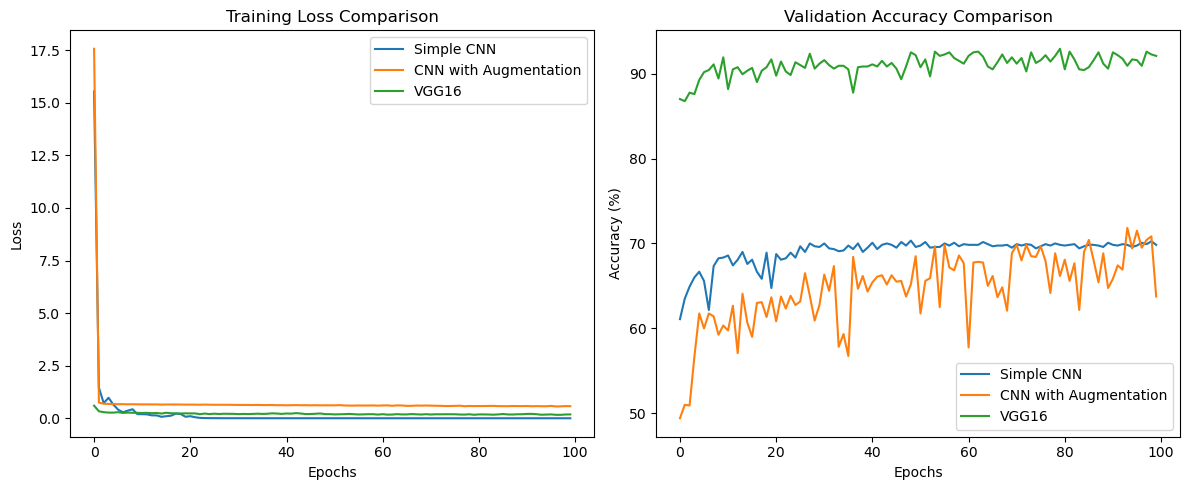

In [11]:
# Function to plot the training losses and validation accuracies for each model
def plot_results(results):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    for model_name, (train_losses, _) in results.items():
        plt.plot(train_losses, label=model_name)  # Plot training losses for each model
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    for model_name, (_, val_accuracies) in results.items():
        plt.plot(val_accuracies, label=model_name)  # Plot validation accuracies for each model
    plt.title('Validation Accuracy Comparison')  # Set the title for the validation accuracy plot
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_results(results)

## **Evaluate the algorithm and report results**

**Simple CNN**: 70.25% accuracy

**Simple CNN with Augmented Data**: 71.5% accuracy

**Pre-Trained VGG16 with Augmented Data**: 92.58% accuracy

VGG16 performed the best, showing a big improvement over the other two models.